# Demonstration of pyQuil simulation capabilities
### Ben Bartlett, 6.27.17

In [1]:
# Import everything
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import pyquil.quil as pq    # Quil language
import pyquil.api as api    # Rigetti forest api
from pyquil.gates import *  # All QC logical gates

In [4]:
def state0011(q1, q2):
    '''Prepare the state |00> + |11> on qubits q1 and q2'''
    return pq.Program(H(q1), CNOT(q1, q2))

In [5]:
def teleportQubit(alice, bob, ancilla):
    '''Perform quantum teleportation from sending to receiving qubits using a single ancilla'''
    # Set registers for Alice's qubit and Bob's ancilla and qubit
    aliceRegister = 0
    ancillaRegister = 1
    bobRegister = 2
    
    # Generate an EPR pair with Bob's receiving and ancillary qubits
    Hilbert = state0011(bob, ancilla)
    
    # Teleport Alice's qubit into Bob's ancilla 
    Hilbert.inst( CNOT(alice, ancilla),
                  H(alice) )
    
    # Measure Alice's qubit and Bob's ancilla and put them in a classical comms line
    Hilbert.measure(alice, aliceRegister)
    Hilbert.measure(ancilla, ancillaRegister)
    
    # Act on Bob's qubit with X and Z accordingly to reconstruct Alice's original state
    Hilbert.if_then(ancillaRegister, X(bob)) # If ancilla collapses to 1, apply X
    Hilbert.if_then(aliceRegister, Z(bob))   # If Alice's state collapses to 1, apply Z
    
    # Measure Bob's qubit
    Hilbert.measure(bob, bobRegister) 
    
    return Hilbert

In [46]:
def teleportationDemo(qvm): 
    '''Executes a few teleportations on the quantum VM qvm'''
    alice, bob, ancilla = 0, 2, 1
    # Teleport |0> 
    demo0 = pq.Program() 
    demo0 += teleportQubit(alice, bob, ancilla) 
    print "Teleporting |0> from Alice to Bob: ", qvm.run(demo0, [bob]) 
    
    # Teleport |1> 
    demo1 = pq.Program(X(alice)) # flip Alice's qubit from |0> to |1>
    demo1 += teleportQubit(alice, bob, ancilla) 
    print "Teleporting |1> from Alice to Bob: ", qvm.run(demo1, [bob]) 
    
    # Teleport 1/sqrt(2)*(|0> + |1>) 
    demo1 = pq.Program(H(alice)) # flip Alice's qubit from |0> to |+>
    demo1 += teleportQubit(alice, bob, ancilla) 
    print "Teleporting 1/sqrt(2)*(|0> + |1>) from Alice to Bob: ", qvm.run(demo1, [bob]) 
    
    print "\n"

In [45]:
def teleportationRotationDemo(qvm):
    '''Tests teleportation capabilities against expected values for range of phases'''
    # Perform teleportation across angles 
    alice, bob, ancilla = 0, 2, 1
    angles = np.linspace(0, 2* np.pi, 20) # Series of angles to be applied to rotation-X operator 
    numRepetitions = 30 # number of trial repetitions for each angle
    results = np.zeros((len(angles), numRepetitions)) # an nAngles * nRepetitions array of results
    print "Performing teleportation rotation test, this may take a while..."
    for i, angle in enumerate(angles):
        for j in range(numRepetitions):
            demo = pq.Program(RX(angle, alice)) 
            demo += teleportQubit(alice, bob, ancilla) 
            measuredResult = qvm.run(demo, [bob])[0][0] # an eigenstate in computational basis 
            results[i,j] = measuredResult # put the result in the array 

    # Compare the results with expected values and make a nice pretty plot
    meanResults = np.mean(results, axis=1)
    expectedResults = np.sin(angles/2)**2
    plt.plot(angles, meanResults, label='Observed') 
    plt.plot(angles, expectedResults, label='Expected')
    plt.legend()
    plt.xlabel("$\Theta$ applied to $R_X$(Alice)")
    plt.ylabel("Teleported qubit measurement") 
    plt.show()

Teleporting |0> from Alice to Bob:  [[0]]
Teleporting |1> from Alice to Bob:  [[1]]
Teleporting 1/sqrt(2)*(|0> + |1>) from Alice to Bob:  [[0]]


Performing teleportation rotation test, this may take a while...


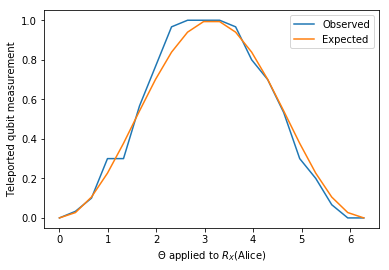

In [47]:
# Set up the quantum vm
qvm = api.SyncConnection() 

# Run the demos
teleportationDemo(qvm)

teleportationRotationDemo(qvm)